<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Split-Train/Test/Validation" data-toc-modified-id="Split-Train/Test/Validation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Split Train/Test/Validation</a></span></li><li><span><a href="#Baseline-model" data-toc-modified-id="Baseline-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Baseline model</a></span></li><li><span><a href="#Models-Training" data-toc-modified-id="Models-Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Models Training</a></span><ul class="toc-item"><li><span><a href="#Light-Gradient-Boosting-Machine-(LGBM)" data-toc-modified-id="Light-Gradient-Boosting-Machine-(LGBM)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Light Gradient Boosting Machine (LGBM)</a></span></li></ul></li></ul></div>

# Libraries

In [23]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Split Train/Test/Validation

In [2]:
data = pd.read_csv('data/eda_dataset_imputed.csv')

app_train, test_1 = train_test_split(data, test_size=0.30, random_state=64)
app_test, app_validation = train_test_split(test_1, test_size=0.5, random_state=56)

In [3]:
app_train.shape, app_test.shape, app_validation.shape

((215257, 451), (46127, 451), (46127, 451))

# Baseline model

In [4]:
train_labels = app_train['TARGET']
test_labels = app_test['TARGET']

In [5]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()

    
if 'TARGET' in app_test:
    test = app_test.drop(columns = ['TARGET'])
else:
    test = app_test.copy()

    
# Feature names
features = list(train.columns)

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (215257, 450)
Testing data shape:  (46127, 450)


In [6]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [7]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [8]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test_labels, log_reg_pred)

0.7109988292401902

In [9]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(test_labels, log_reg_pred)

0.14895447690010147

# Models Training

## Light Gradient Boosting Machine (LGBM)

In [18]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.utils.multiclass import type_of_target

import gc

def model(features, test_features, lgbm_params, n_folds = 5): 
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        
    Return
    --------
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = np.array(features['TARGET'].astype(int))
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(application="binary", boosting_type=lgbm_params["boosting"],
                          learning_rate=lgbm_params["learning_rate"],n_estimators=lgbm_params["n_estimators"],
                          reg_alpha = lgbm_params["reg_alpha"], reg_lambda = lgbm_params["reg_lambda"], 
                          drop_rate=lgbm_params["drop_rate"],
                          num_leaves=lgbm_params["num_leaves"], max_depth=lgbm_params["max_depth"],
                          max_bin=lgbm_params["max_bin"],
                          subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = ['auc', 'mae'],
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'],
                  early_stopping_rounds = 200, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return feature_importances, metrics

In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [19]:
lgbm_params = {
    "boosting":"dart",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':0.01,
    'reg_lambda': 0.01,
    "n_estimators":10000,
    "max_depth":7,
    "num_leaves":100,
    "max_bin":225,
    "drop_rate":0.02
}

fi, metrics = model(app_train, app_test, lgbm_params=lgbm_params)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (215257, 449)
Testing Data Shape:  (46127, 449)
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138306	valid's auc: 0.75493	train's l1: 0.1304	train's auc: 0.878402
Early stopping, best iteration is:
[166]	valid's l1: 0.138346	valid's auc: 0.755672	train's l1: 0.131516	train's auc: 0.867146
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139016	valid's auc: 0.750802	train's l1: 0.130111	train's auc: 0.87597
[400]	valid's l1: 0.137323	valid's auc: 0.751419	train's l1: 0.12313	train's auc: 0.919889
[600]	valid's l1: 0.135929	valid's auc: 0.749653	train's l1: 0.118465	train's auc: 0.940436
Early stopping, best iteration is:
[412]	valid's l1: 0.137586	valid's auc: 0.751572	train's l1: 0.123416	train's auc: 0.920606
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13811	valid's auc: 0.740441	train's l1: 0.130498	train's auc: 0.877859
[400]	valid's l1: 0.136333	valid'

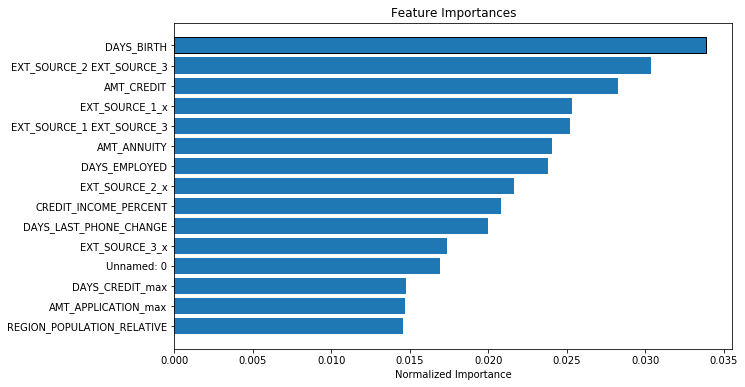

In [24]:
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 449)
Testing Data Shape:  (46127, 449)
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135566	valid's auc: 0.756938	train's l1: 0.131071	train's auc: 0.828537
Early stopping, best iteration is:
[130]	valid's l1: 0.136014	valid's auc: 0.757189	train's l1: 0.13316	train's auc: 0.808128
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136443	valid's auc: 0.752111	train's l1: 0.130766	train's auc: 0.826718
Early stopping, best iteration is:
[146]	valid's l1: 0.136747	valid's auc: 0.752978	train's l1: 0.132313	train's auc: 0.812596
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135256	valid's auc: 0.741588	train's l1: 0.131067	train's auc: 0.828268
Early stopping, best iteration is:
[139]	valid's l1: 0.135558	valid's auc: 0.742579	train's l1: 0.132704	train's auc: 0.812905
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13

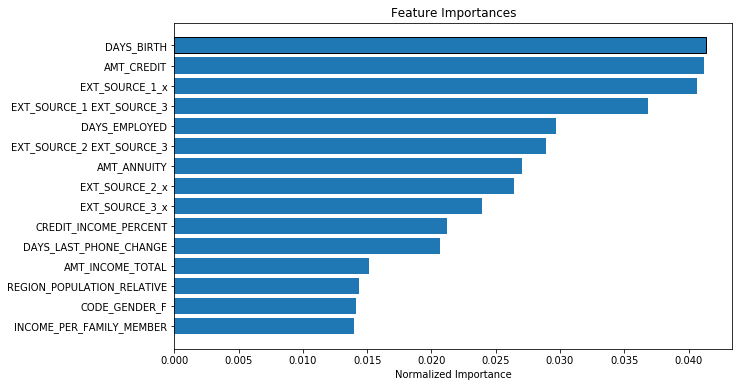

In [27]:
lgbm_params = {
    "boosting":"gbdt",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':0.1,
    'reg_lambda': 0.1,
    "n_estimators":10000,
    "max_depth":5,
    "num_leaves":200,
    "max_bin":225,
    "drop_rate":0.02
}

fi, metrics = model(app_train, app_test, lgbm_params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 449)
Testing Data Shape:  (46127, 449)
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133943	valid's auc: 0.749703	train's l1: 0.119879	train's auc: 0.913331
Early stopping, best iteration is:
[65]	valid's l1: 0.136194	valid's auc: 0.753318	train's l1: 0.130371	train's auc: 0.847388
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134599	valid's auc: 0.748537	train's l1: 0.119719	train's auc: 0.91164
Early stopping, best iteration is:
[96]	valid's l1: 0.136173	valid's auc: 0.750691	train's l1: 0.127529	train's auc: 0.863436
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133589	valid's auc: 0.738573	train's l1: 0.120909	train's auc: 0.905562
Early stopping, best iteration is:
[111]	valid's l1: 0.134897	valid's auc: 0.740966	train's l1: 0.126919	train's auc: 0.87136
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13459

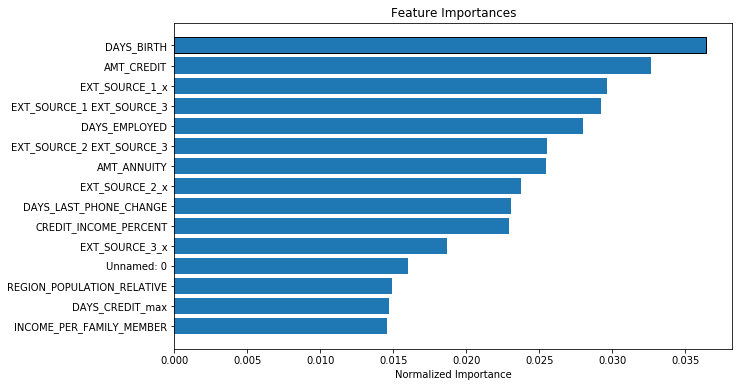

In [30]:
lgbm_params = {
    "boosting":"gbdt",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':0.1,
    'reg_lambda': 0.1,
    "n_estimators":10000,
    "max_depth":7,
    "num_leaves":200,
    "max_bin":225,
    "drop_rate":0.02
}

fi, metrics = model(app_train, app_test, lgbm_params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 449)
Testing Data Shape:  (46127, 449)
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13569	valid's auc: 0.75843	train's l1: 0.132836	train's auc: 0.804785
Early stopping, best iteration is:
[150]	valid's l1: 0.135888	valid's auc: 0.758667	train's l1: 0.133925	train's auc: 0.79371
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136407	valid's auc: 0.754945	train's l1: 0.132427	train's auc: 0.80513
[400]	valid's l1: 0.135644	valid's auc: 0.75478	train's l1: 0.128452	train's auc: 0.843975
Early stopping, best iteration is:
[382]	valid's l1: 0.135689	valid's auc: 0.755204	train's l1: 0.128808	train's auc: 0.840568
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135179	valid's auc: 0.744696	train's l1: 0.132866	train's auc: 0.80637
[400]	valid's l1: 0.134526	valid's auc: 0.744106	train's l1: 0.128731	train's auc: 0.845455
Early stopping, best iteration is

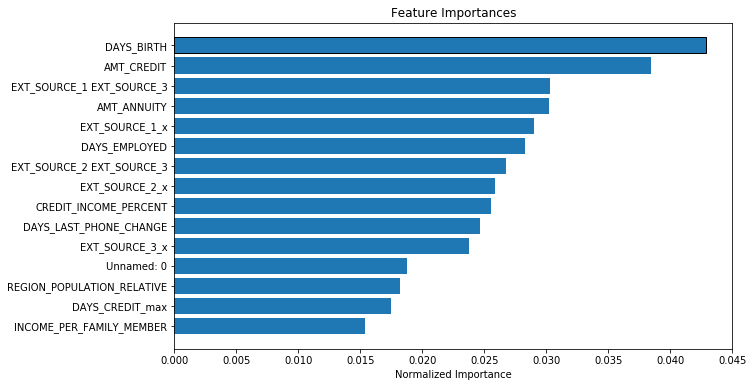

In [31]:
lgbm_params = {
    "boosting":"gbdt",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':10,
    'reg_lambda': 10,
    "n_estimators":10000,
    "max_depth":5,
    "num_leaves":200,
    "max_bin":225,
    "drop_rate":0.02
}

fi, metrics = model(app_train, app_test, lgbm_params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 449)
Testing Data Shape:  (46127, 449)
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13569	valid's auc: 0.75843	train's l1: 0.132836	train's auc: 0.804785
Early stopping, best iteration is:
[150]	valid's l1: 0.135888	valid's auc: 0.758667	train's l1: 0.133925	train's auc: 0.79371
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136407	valid's auc: 0.754945	train's l1: 0.132427	train's auc: 0.80513
[400]	valid's l1: 0.135644	valid's auc: 0.75478	train's l1: 0.128452	train's auc: 0.843975
Early stopping, best iteration is:
[382]	valid's l1: 0.135689	valid's auc: 0.755204	train's l1: 0.128808	train's auc: 0.840568
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135179	valid's auc: 0.744696	train's l1: 0.132866	train's auc: 0.80637
[400]	valid's l1: 0.134526	valid's auc: 0.744106	train's l1: 0.128731	train's auc: 0.845455
Early stopping, best iteration is

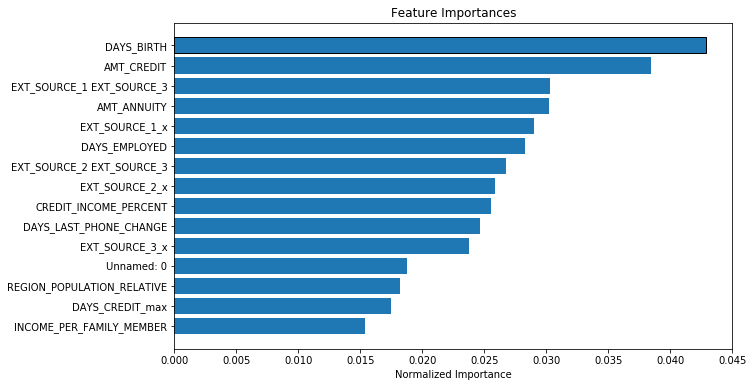

In [33]:
lgbm_params = {
    "boosting":"gbdt",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':10,
    'reg_lambda': 10,
    "n_estimators":10000,
    "max_depth":5,
    "num_leaves":200,
    "max_bin":225,
    "drop_rate":0.02
}

fi, metrics = model(app_train, app_test, lgbm_params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)